## Importing the necessary libraries

In [1]:
import numpy as np
import pandas as pd

In [2]:
!pip install transformers --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 19.7 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from wordcloud import WordCloud
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.metrics import confusion_matrix, classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
plt.rcParams['figure.figsize'] = (12,8)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Preprocessing 

In [6]:
# remove hashtags
def hashtags(text):
    hash = re.findall(r"#(\w+)", text)
    return hash

# remove retweet username and tweeted at @username
def remove_users(tweet):
    '''Takes a string and removes retweet and @user information'''
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) 
    # remove tweeted at
    return tweet

# remove links
def remove_links(tweet):
    '''Takes a string and removes web links from it'''
    tweet = re.sub(r'http\S+', '', tweet) # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet) # remove bitly links
    tweet = tweet.strip('[link]') # remove [links]
    return tweet

def clean_html(text):
    html = re.compile('<.*?>')#regex
    return html.sub(r'',text)

# remove non ascii character
def non_ascii(s):
    return "".join(i for i in s if ord(i)<128)

def lower(text):
    return text.lower()

# remove stopwords
def removeStopWords(str):
    #select english stopwords
    cachedStopWords = set(stopwords.words("english"))
    #add custom words
    cachedStopWords.update(('and','I','A','http','And','So','arnt','This','When','It','many','Many','so','cant','Yes','yes','No','no','These','these','mailto','regards','ayanna','like','email'))
    #remove stop words
    new_str = ' '.join([word for word in str.split() if word not in cachedStopWords]) 
    return new_str

# remove email address
def email_address(text):
    email = re.compile(r'[\w\.-]+@[\w\.-]+')
    return email.sub(r'',text)

def punct(text):
    token=RegexpTokenizer(r'\w+')#regex
    text = token.tokenize(text)
    text= " ".join(text)
    return text 

# remove digits and special characters
def remove_digits(text):
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' 
    #when the ^ is on the inside of []; we are matching any character that is not included in this expression within the []
    return re.sub(pattern, '', text)

def remove_special_characters(text):
    # define the pattern to keep
    pat = r'[^a-zA-z0-9.,!?/:;\"\'\s]' 
    return re.sub(pat, '', text)

def remove_(tweet):
    tweet = re.sub('([_]+)', "", tweet)
    return tweet

## Loading the dataset

In [7]:
path = "/content/drive/MyDrive/NLP/Project1/"

In [8]:
names = ["class", "sms"]
df = pd.read_csv(path + "SMSSpamCollection.fwf", names=names, sep="\t")
df.sample(10)

,class,sms
3761,ham,We'll join the &lt;#&gt; bus
1730,ham,Lol yeah at this point I guess not
4985,spam,goldviking (29/M) is inviting you to be his friend. Reply YES-762 or NO-762 See him: www.SMS.ac/u/goldviking STOP? Send STOP FRND to 62468
3656,ham,Senthil group company Apnt 5pm.
3857,ham,I'm ok. Will do my part tomorrow
1473,ham,"Just sent you an email – to an address with incomm in it, is that right?"
946,ham,I cant wait to see you! How were the photos were useful? :)
1980,ham,Shhhhh nobody is supposed to know!
2254,ham,Lol enjoy role playing much?
3,ham,U dun say so early hor... U c already then say...


## Feature Engineering

In [9]:
df.shape

(5572, 2)

In [10]:
df.isna().sum()

class    0
sms      0
dtype: int64

In [11]:
df.duplicated().sum()

403

In [12]:
df = df.drop_duplicates()
df.shape

(5169, 2)

In [13]:
df = df.dropna()
df.shape

(5169, 2)

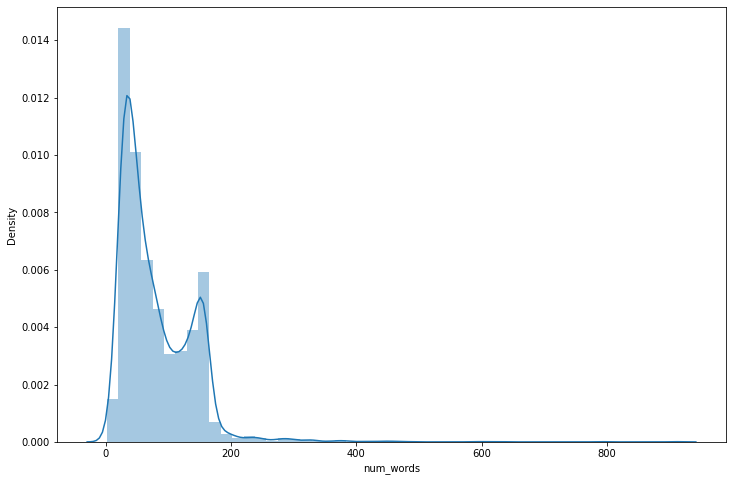

In [14]:
df['num_words'] = df['sms'].apply(len)
sns.distplot(df.num_words);

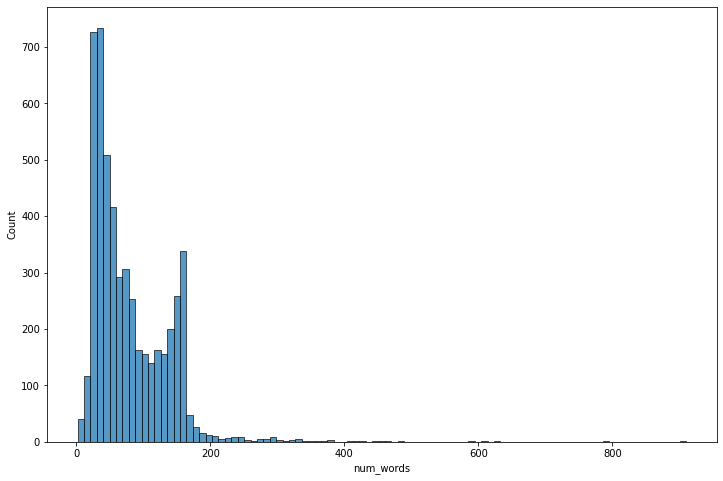

In [15]:
sns.histplot(df.num_words);

In [16]:
print(f"Average number of words in an tweet:{df.num_words.mean():.2f}")

Average number of words in an tweet:79.34


In [17]:
df.num_words.describe()

count    5169.000000
mean       79.344554
std        58.437457
min         2.000000
25%        36.000000
50%        61.000000
75%       119.000000
max       910.000000
Name: num_words, dtype: float64

In [18]:
max_len = 80

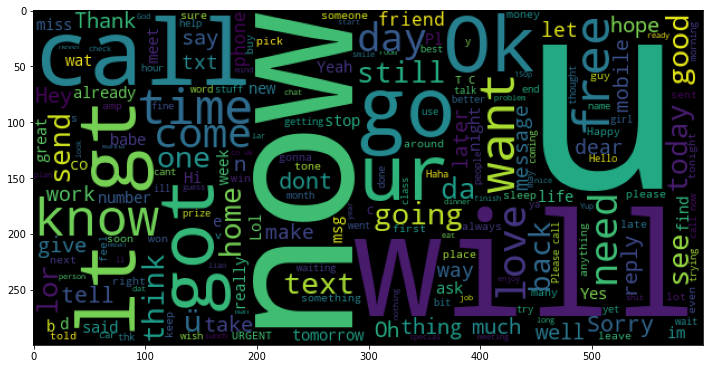

In [19]:
wc = WordCloud(width=600,height=300,random_state=101).generate(' '.join(df["sms"]))
plt.imshow(wc);

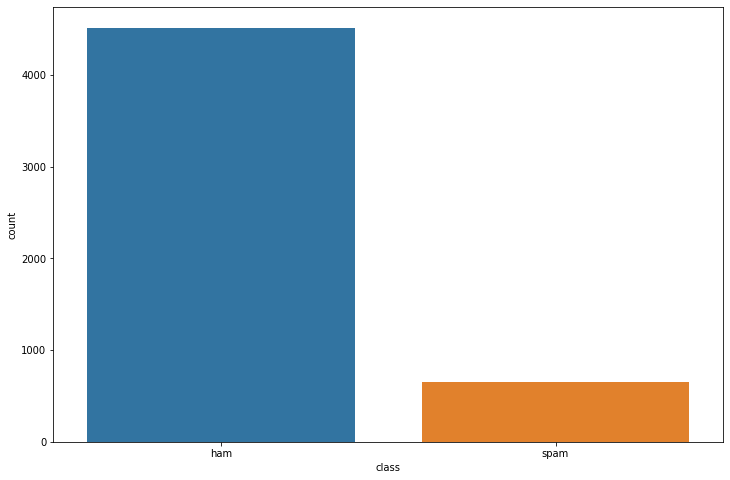

In [20]:
sns.countplot(df['class'])

## Text Preprocessing

In [21]:
def text_preprocess(data,col):
    data[col] = data[col].apply(func=clean_html)
    data[col] = data[col].apply(func=remove_)
    data[col] = data[col].apply(func=removeStopWords)
    data[col] = data[col].apply(func=remove_digits)
    data[col] = data[col].apply(func=remove_links)
    data[col] = data[col].apply(func=remove_special_characters)
    data[col] = data[col].apply(func=punct)
    data[col] = data[col].apply(func=non_ascii)
    data[col] = data[col].apply(func=email_address)
    data[col] = data[col].apply(func=lower)
    return data

In [22]:
preprocessed_df = text_preprocess(df,'sms')

In [23]:
preprocessed_df.sample(10)

,class,sms,num_words
5502,ham,apo mokka players,36
2604,ham,im arestaurant eating squid wanna dosomething late,95
1057,ham,then u drive lor,17
5266,ham,hi darlin its kate are u up for doin somethin tonight im going to pub called the swan or something with my parents for one drink so phone me if u can,152
1068,ham,meeting u work tel shall work tomorrow,65
3293,ham,dear good morning feeling dear,38
2463,ham,rose needs water season needs change poet needs imagination my phone needs ur sms need ur lovely frndship forever,126
5420,ham,dont know oh hopefully month,37
5102,spam,msg mobile content order resent previous attempt failed due network error queries customersqueriesnetvision uk com,153
3910,ham,serious what proper tongued,37


## Splitting the dataset into training and test sets

In [24]:
train_df, test_df = train_test_split(preprocessed_df,test_size=0.2,random_state=42,shuffle=True,stratify=preprocessed_df["class"])

In [25]:
train_df.sample(5)

,class,sms,num_words
397,ham,was actually sleeping still might u call back text gr you rock sis will send u text wen wake,118
428,ham,any pain urination thing else,37
774,ham,wil lt gt minutes got space,57
2885,ham,cbe really good nowadays lot shop showrooms city shaping good,77
3310,ham,okie wan meet bishan cos bishan now i m driving today,71


In [26]:
train_df.shape, test_df.shape 

((4135, 3), (1034, 3))

## Encode `Sentiment` as class

In [27]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(train_df["class"].values)
y_test = encoder.fit_transform(test_df["class"].values)

In [28]:
print(y_train[0:5])

[0 0 0 0 0]


## Loading the pretrained Tokenizer class and the pretrained BERT-BASE-Uncased transformer model

In [29]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
roberta = TFAutoModelForSequenceClassification.from_pretrained("bert-base-cased",from_pt=True)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Performing text tokenization

In [30]:
X_train = tokenizer(text=train_df["sms"].tolist(),
                   max_length=max_len,
                   padding=True,
                   truncation=True,
                   add_special_tokens=True,
                   return_tensors="tf",
                   return_attention_mask=True,
                   return_token_type_ids=False,
                   verbose=True)
X_test = tokenizer(text=test_df["sms"].tolist(),
                  max_length=max_len,
                  padding=True,
                  truncation=True,
                  add_special_tokens=True,
                  return_tensors="tf",
                  return_attention_mask=True,
                  return_token_type_ids=False,
                  verbose=True)

In [31]:
train_df["sms"][0]

'go jurong point crazy available bugis n great world la e buffet cine got amore wat'

In [32]:
X_train['input_ids'][0]

<tf.Tensor: shape=(80,), dtype=int32, numpy=
array([  101, 27629,  1810, 22118, 22118,  1313, 17943,  1253,   102,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0],
      dtype=int32)>

In [33]:
X_train['attention_mask'][0]

<tf.Tensor: shape=(80,), dtype=int32, numpy=
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)>

## Fine-tuning the ROBERTA transformer model architecture

In [34]:
input_ids = Input(shape=(max_len,),dtype=tf.int32,name='input_ids')
attention_mask = Input(shape=(max_len,),dtype=tf.int32,name='attention_mask')

In [35]:
embeddings = roberta(input_ids,attention_mask=attention_mask)[0] # 0 --> final hidden state, 1 --> pooling output
output = Flatten()(embeddings)

output = Dense(units=1024,activation='relu')(output)
# output = BatchNormalization()(output)
output = Dropout(0.3)(output)

output = Dense(units=512,activation='relu')(output)
# output = BatchNormalization()(output)
output = Dropout(0.2)(output)

output = Dense(units=256,activation='relu')(output)
# output = BatchNormalization()(output)
output = Dropout(0.1)(output)

output = Dense(units=128,activation='relu')(output)
# output = BatchNormalization()(output)
output = Dense(units=2,activation='softmax')(output)

model = Model(inputs=[input_ids,attention_mask],outputs=output)
model.layers[2].trainable = True

In [36]:
model.layers[2]

## Visualizing the model architecture

In [37]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 80)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 80)]         0           []                               
                                                                                                  
 tf_bert_for_sequence_classific  TFSequenceClassifie  108311810  ['input_ids[0][0]',              
 ation (TFBertForSequenceClassi  rOutput(loss=None,               'attention_mask[0][0]']         
 fication)                      logits=(None, 2),                                                 
                                 hidden_states=None                                           

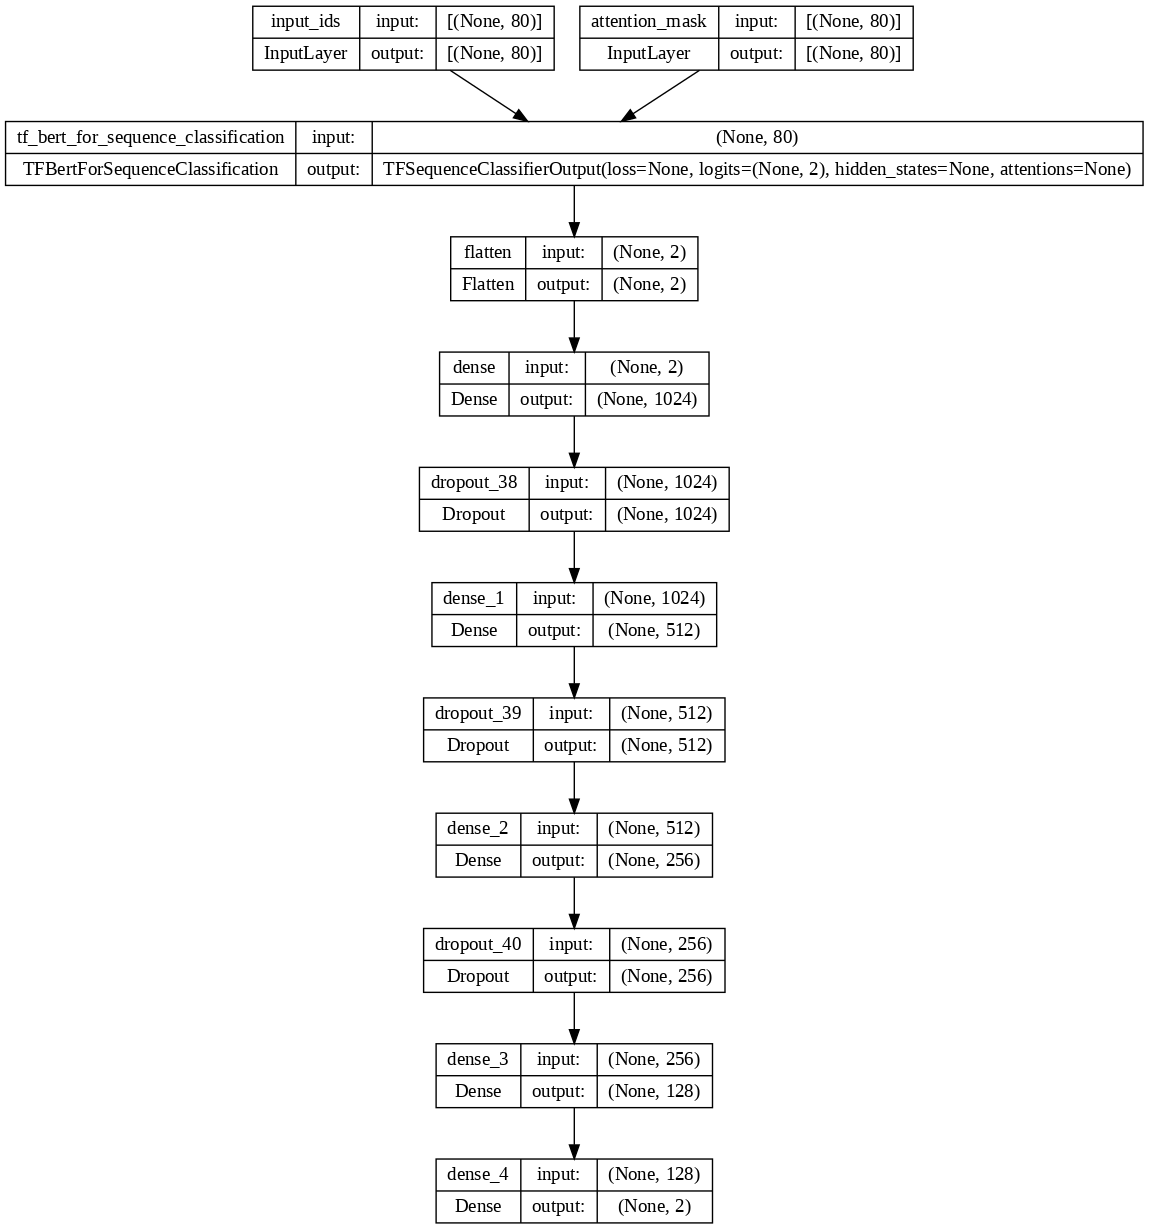

In [38]:
plot_model(model,'BERT-BASE-FINETUNED.png',dpi=100,show_shapes=True)

## Compiling the model

In [39]:
optimizer = Adam(learning_rate=5e-5,epsilon=2e-8,clipnorm=1.0)
loss = CategoricalCrossentropy(from_logits=True)
# metrics = Accuracy(name="accuracy", dtype=None)
model.compile(loss=loss,optimizer=optimizer,metrics=["accuracy"])

## Training the fine-tuned ROBERTA transformer model

In [40]:
es = EarlyStopping(monitor='val_accuracy',
                   patience=3,
                   verbose=1,
                   mode='max')
filepath="weights-{epoch:02d}.hdf5"
mc = ModelCheckpoint(filepath=filepath,
                     monitor='val_accuracy',
                     mode='max',
                     save_best_only=True,
                     verbose=1)

In [41]:
r = model.fit(x={'input_ids': X_train['input_ids'], 
                 'attention_mask': X_train['attention_mask']},
              y=to_categorical(y_train),
              epochs=10,
              batch_size=32,
              callbacks=[es,mc],
              validation_data=({'input_ids': X_test['input_ids'], 
                                'attention_mask': X_test['attention_mask']},
                               to_categorical(y_test))
             )

Epoch 1/10
130/130 [==============================] - ETA: 0s - loss: 0.2602 - accuracy: 0.8938
Epoch 1: val_accuracy improved from -inf to 0.97776, saving model to weights-01.hdf5
130/130 [==============================] - 155s 692ms/step - loss: 0.2602 - accuracy: 0.8938 - val_loss: 0.0877 - val_accuracy: 0.9778
Epoch 2/10
130/130 [==============================] - ETA: 0s - loss: 0.0709 - accuracy: 0.9828
Epoch 2: val_accuracy improved from 0.97776 to 0.98259, saving model to weights-02.hdf5
130/130 [==============================] - 80s 616ms/step - loss: 0.0709 - accuracy: 0.9828 - val_loss: 0.0510 - val_accuracy: 0.9826
Epoch 3/10
130/130 [==============================] - ETA: 0s - loss: 0.0468 - accuracy: 0.9898
Epoch 3: val_accuracy did not improve from 0.98259
130/130 [==============================] - 74s 572ms/step - loss: 0.0468 - accuracy: 0.9898 - val_loss: 0.0867 - val_accuracy: 0.9787
Epoch 4/10
130/130 [==============================] - ETA: 0s - loss: 0.0455 - accura

## Analyzing the overall performance of the fine-tuned BERT transformer model

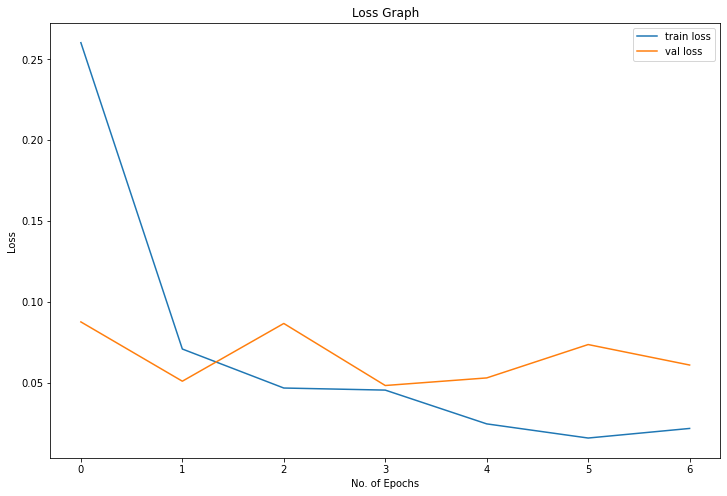

In [42]:
plt.plot(r.history['loss'],label='train loss')
plt.plot(r.history['val_loss'],label='val loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

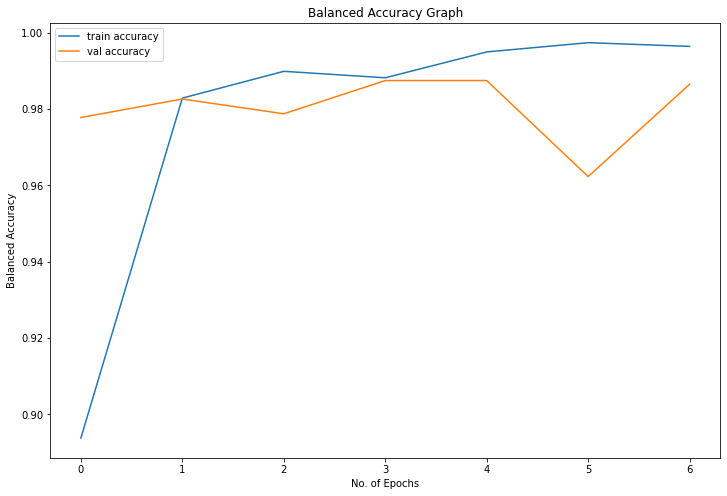

In [44]:
plt.plot(r.history['accuracy'],label='train accuracy')
plt.plot(r.history['val_accuracy'],label='val accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Balanced Accuracy')
plt.title('Balanced Accuracy Graph')
plt.legend();

## Saving the model

In [48]:
model.save(path + 'sms_spam_detector.h5')

## Model Evaluation

In [47]:
loss, acc = model.evaluate({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},to_categorical(y_test))
print("Test Categorical Crossentropy Loss:", loss)
print("Test Categorical Accuracy:", acc)

33/33 [==============================] - 6s 181ms/step - loss: 0.0610 - accuracy: 0.9865
Test Categorical Crossentropy Loss: 0.061034463346004486
Test Categorical Accuracy: 0.9864603281021118


In [46]:
test_predictions = model.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']})
test_predictions = np.argmax(test_predictions,axis=1)
print("Confusion Matrix:")
print(confusion_matrix(y_test,test_predictions))
print("Classification Report:")
print(classification_report(y_test,test_predictions))

33/33 [==============================] - 9s 169ms/step
Confusion Matrix:
[[897   6]
 [  8 123]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       903
           1       0.95      0.94      0.95       131

    accuracy                           0.99      1034
   macro avg       0.97      0.97      0.97      1034
weighted avg       0.99      0.99      0.99      1034

